# Offshore CIOPS Quantitative Runs
### using huyer 1998's divisions

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import datetime as dt
import math
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor as LOF
from matplotlib.gridspec import GridSpec

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [3]:
meander = 0
init = 1
North = 2
Sshelf = 5
Sslope = 4
Offshore = 3

In [4]:
saltdiv = 32

tide = 24
offcut = 595 

#from huyer 1998, Masson 2006, and Sahu 2022
sdiv = 33.9

## summer 2017

In [13]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [6]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [7]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [25]:
north = [np.sum(data.init_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

offshore = [np.sum(data.init_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) 
                                    & (data.final_x <= offcut) & (data.init_t >= sum_start[i]) 
                                    & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                    for i in range(len(sum_start))]

cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= sum_start[i])
                               & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                               for i in range(len(sum_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.init_t >= sum_start[i]) & 
                                 (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

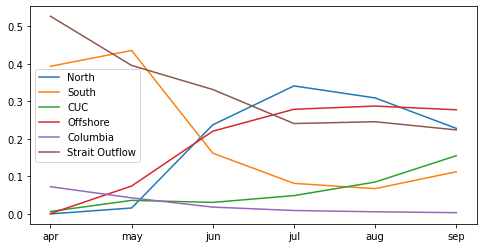

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(monS, north, label = "North")
ax.plot(monS, south, label = "South")
ax.plot(monS, cuc, label = "CUC")
ax.plot(monS, offshore, label='Offshore')
ax.plot(monS, fresh, label = "Columbia")
ax.plot(monS, loop, label = "Strait Outflow")

# ax.plot(monS, meander, label = "Strait Outflow")
ax.legend()

In [14]:
# lets say actually that the "summer" started on May 20
# bring it all together
n = 20 # days into may
start = h+sum(mon_len[:1])*24+n*24
end = h+sum(mon_len)*24-1

mon_sum_ = np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= start) & (data.init_t <= end)])/(end-start+1)
loop = np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= start) & (data.init_t <= end)])/(end-start+1)
mon_sum = loop+mon_sum_

In [15]:
#tidally pumped
np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t <= tide) & (data.init_t >= start) & (data.init_t <= end)])/np.sum(data.final_transp)

<xarray.DataArray 'final_transp' ()>
array(0.51954945)

In [28]:
north =np.sum(data.init_transp[(data.final_section==North) & (data.init_t >= start) 
                                 & (data.init_t <= end)])/(end-start+1) 

offshore =np.sum(data.init_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) 
                                    & (data.final_x <= offcut) & (data.init_t >= start) 
                                    & (data.init_t <= end)])/(end-start+1) 

cuc =np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= start)
                               & (data.init_t <= end)])/(end-start+1)

south =np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= start) 
                                 & (data.init_t <= end)])/(end-start+1) 

fresh =np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.init_t >= start) & 
                                 (data.init_t <= end)])/(end-start+1) 

Text(0, 0.5, 'Percentage of JdF Inflow')

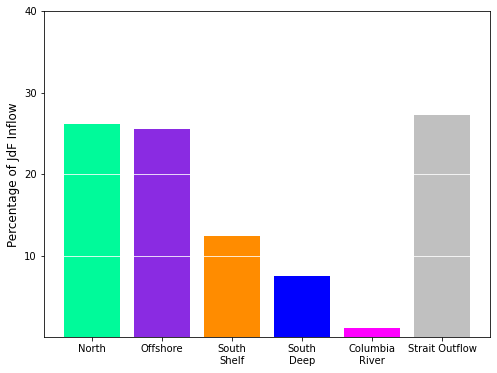

In [29]:
#bar plot of contribution
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait Outflow']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north/mon_sum*100,offshore/mon_sum*100, south/mon_sum*100,cuc/mon_sum*100, fresh/mon_sum*100, loop/mon_sum*100], color=colors)
ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [30]:
# percentages w/out loop
total_bar = sum([north/mon_sum*100,offshore/mon_sum*100, south/mon_sum*100,cuc/mon_sum*100, fresh/mon_sum*100])
np.array([north/mon_sum*100,offshore/mon_sum*100, south/mon_sum*100,cuc/mon_sum*100, fresh/mon_sum*100])/total_bar.values*100

array([35.93039548, 35.00816896, 17.13155461, 10.38382588,  1.54605507])

In [31]:
np.array([north/mon_sum*100,offshore/mon_sum*100, south/mon_sum*100,cuc/mon_sum*100, fresh/mon_sum*100,loop/mon_sum*100])

array([26.14949117, 25.47831141, 12.46803521,  7.55716043,  1.12519088,
       27.2218109 ])

### Sv calcs

In [32]:
print('north = '+ str(north.values/1000) + ' mSv')
print('offshore = '+ str(offshore.values/1000) + ' mSv')
print('cuc = '+ str(cuc.values/1000) + ' mSv')
print('south = '+ str(south.values/1000) + ' mSv')
print('fresh = '+ str(fresh.values/1000) + ' mSv')
print('loop = '+ str(loop.values/1000) + ' mSv')


north = 26.872763761418206 mSv
offshore = 26.18301974132964 mSv
cuc = 7.766185037077503 mSv
south = 12.812890415171797 mSv
fresh = 1.1563127027355973 mSv
loop = 27.97474294271811 mSv


In [33]:
indep = -150

print('cuc deep = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth <= indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('cuc shallow = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth > indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('\n')
print('south deep = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth <= indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('south shallow = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth > indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('\n')
print('offshore deep = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('offshore shallow = '+ str(np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('offshore start deep = '+ str(np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('\n')
print('north deep = '+ str(np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('north shallow = '+ str(np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')
print('\n')
print('meander = '+ str(np.sum(data.final_transp[(data.final_section==0) & (abs(data.init_t-data.final_t)<24) & (data.init_t >=start) & (data.init_t <=end)]).values/(end-start+1)/1000) + ' mSv')

cuc deep = 1.3175283078867714 mSv
cuc shallow = 6.448656729190733 mSv


south deep = 3.0363196304249644 mSv
south shallow = 9.776570784746832 mSv


offshore deep = 5.393691351948421 mSv
offshore shallow = 20.789328389381225 mSv
offshore start deep = 11.356943348570233 mSv


north deep = 5.130582984344977 mSv
north shallow = 21.74218077707323 mSv


meander = 329.2253739030461 mSv


## winter 2016/17

In [16]:
dataS= xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [17]:
#tidally pumped
np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t <= tide)])/np.sum(data.final_transp)

<xarray.DataArray 'final_transp' ()>
array(0.77448242)

In [35]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [36]:
mons = np.append(mon16, ['apr17'])

mon_sum_ = np.append([np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                    [np.sum(dataS.final_transp[(dataS.final_section!=0) & (np.isnan(dataS.final_section)==False) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0]])

loop_ = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t-dataS.final_t > tide) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0]])
mon_sum = loop_+mon_sum_
loop = loop_/mon_sum

In [37]:
cuc = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)  & (data.final_salt >= sdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt >= sdiv) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0]])

south = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt < sdiv) & (data.final_salt >= saltdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt < sdiv) & (dataS.final_salt >= saltdiv) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0]])

fresh = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)  & (data.final_salt < saltdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt < saltdiv)  & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0]])
north = np.append([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0]])

offshore = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Offshore),(dataS.final_section==Sslope)) & (dataS.final_x <= offcut) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0]])

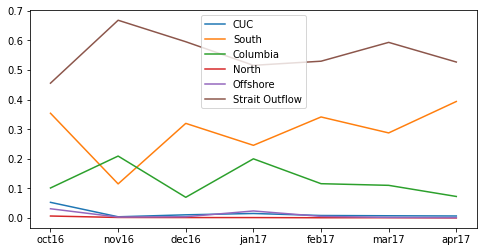

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mons, cuc, label = "CUC")
ax.plot(mons, south, label = "South")
ax.plot(mons, fresh, label = "Columbia")
ax.plot(mons, north, label = "North")
ax.plot(mons, offshore, label = "Offshore")
ax.plot(mons, loop, label = "Strait Outflow")

ax.legend()

In [39]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100,south[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100,fresh[6]*mon_sum[6]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100,north[6]*mon_sum[6]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100,offshore[6]*mon_sum[6]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100,loop[6]*mon_sum[6]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

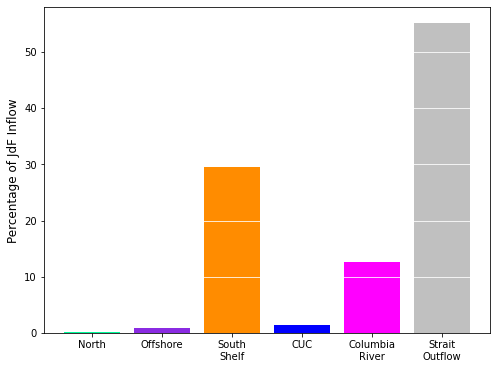

In [40]:
#bar plot of contribution
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = [ 'North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver', 'Strait\nOutflow']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [41]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[0.1594350537204177,
 1.007599015553305,
 29.567208428093934,
 1.4693057813631316,
 12.602938983111217,
 55.193512738157985]

In [42]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 0.35583029,  2.24877931, 65.98867761,  3.27922556, 28.12748723])

### Sv

In [43]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 0.13830743361831585 mSv
offshore = 0.8740765014066195 mSv
cuc = 1.274599952010833 mSv
south = 25.64909423318252 mSv
fresh = 10.9328538870691 mSv
loop = 47.87951533281207 mSv


## winter 2017/18

In [18]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [20]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h+20*24, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24] # added the 10 to win start to get it to start on october 10
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [21]:
#tidally pumped
np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t <= tide) & (data.init_t >= win_start[0])])/np.sum(data.final_transp)

<xarray.DataArray 'final_transp' ()>
array(0.68589141)

In [47]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [48]:
cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= win_start[i])
                               & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                               for i in range(len(win_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= win_start[i]) 
                                 & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.init_t >= win_start[i]) & 
                                 (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
offshore = [np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]

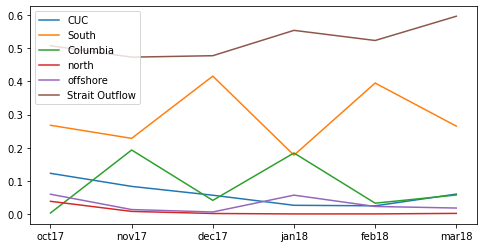

In [49]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mon17, cuc, label = "CUC")
ax.plot(mon17, south, label = "South")
ax.plot(mon17, fresh, label = "Columbia")
ax.plot(mon17, north, label = "north")
ax.plot(mon17, offshore, label = "offshore")
ax.plot(mon17, loop, label = "Strait Outflow")


ax.legend()

In [50]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

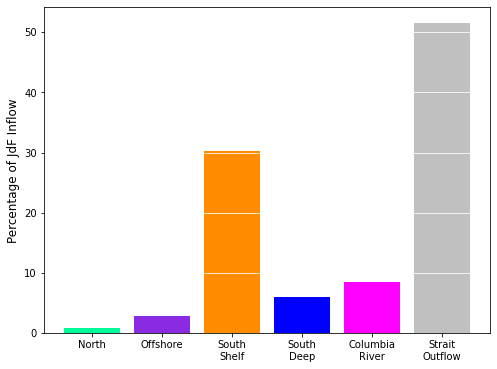

In [51]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait\nOutflow']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']

ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [52]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[0.7961740376679289,
 2.7981709036240976,
 30.302500403986844,
 6.052356729133236,
 8.452015518194022,
 51.59878240739386]

In [54]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 1.6449463 ,  5.78119941, 62.60689692, 12.5045547 , 17.46240268])

### Sv

In [55]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 0.685337140887809 mSv
offshore = 2.4086322287301623 mSv
cuc = 5.20979667778025 mSv
south = 26.084031890125218 mSv
fresh = 7.27539441871933 mSv
loop = 44.41561811278833 mSv


In [57]:
indep = -150

print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (abs(data.init_t-data.final_t)<24) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')

cuc deep = 1.1467882527640751 mSv


cuc shallow = 4.063008425016174 mSv


south deep = 7.251467742375057 mSv
south shallow = 18.83256414775016 mSv


offshore deep = 0.5158863166529805 mSv
offshore shallow = 1.8927459120771812 mSv
offshore start deep = 0.11402102671025692 mSv


north deep = 0.13879295473208086 mSv
north shallow = 0.5465441861557282 mSv


meander = 347.02487127127654 mSv


# bring it all together

In [58]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope) & (mydata.final_x > offcut)) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north16 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop16 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]

freshS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cucS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
southS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
northS = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoreS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loopS = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv)& (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north17 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop17 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


fresh = np.append(np.append(fresh16, freshS), fresh17)
south = np.append(np.append(south16, southS), south17)
north = np.append(np.append(north16, northS), north17)
cuc = np.append(np.append(cuc16, cucS), cuc17)
offshore = np.append(np.append(offshore16, offshoreS), offshore17)
loop = np.append(np.append(loop16, loopS), loop17)

In [59]:
# south shallow
shallow = -50

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]
south_shallow16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope) & (mydata.final_x > offcut)) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]
south_shallowS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

south_shallow17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

south_shallow = np.append(np.append(south_shallow16, south_shallowS), south_shallow17)


In [60]:
def running_mean(x, N):

    # Compute the cumulative sum while ignoring NaNs.
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    # Create a boolean array where True represents non-NaN elements.
    non_nan = np.insert(~np.isnan(x), 0, 0)
    # Compute the cumulative count of non-NaN elements.
    count = np.cumsum(non_nan)
    
    # Calculate the total sum for each window.
    total_sum = cumsum[N:] - cumsum[:-N]
    # Calculate the count of non-NaN elements in each window.
    valid_count = count[N:] - count[:-N]
    
    # Use np.divide to safely divide, turning 0/0 into NaN instead of raising an error.
    return np.divide(total_sum, valid_count, out=np.zeros_like(total_sum), where=valid_count!=0)


In [61]:
N = 4
loop_avg = running_mean(loop, N)

In [62]:
dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(cuc))]

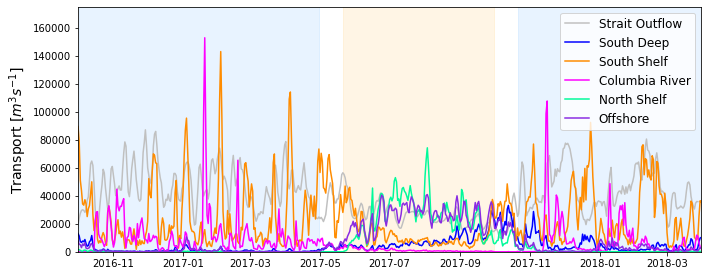

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plt.rcParams['font.size'] = 12
ax.plot(dates[:-(N-1)], loop_avg, label = "Strait Outflow", c='silver')
ax.plot(dates, cuc, label = "South Deep", c='b',zorder=2)
ax.plot(dates, south, label = "South Shelf", c='darkorange',zorder=2)
ax.plot(dates, fresh, label = "Columbia River", c='magenta',zorder=2)
ax.plot(dates, north, label = "North Shelf", c='mediumspringgreen',zorder=2)
ax.plot(dates, offshore, label = "Offshore", c='blueviolet',zorder=2)
ax.legend(loc='upper right')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.set_ylim([0,175000])
ax.set_xlim([dates[0],dates[-1]])

ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=9,day=30))&(np.array(dates)>dt.datetime(year=2017,month=5,day=20)), color='orange',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2018,month=3,day=31))&(np.array(dates)>dt.datetime(year=2017,month=10,day=20)), color='dodgerblue',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=4,day=30))&(np.array(dates)>dt.datetime(year=2016,month=10,day=1)), color='dodgerblue',alpha=0.1,zorder=0)


plt.tight_layout()


In [64]:
cols = ['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD','GST']
wind = pd.read_csv('lapush.csv', usecols=cols, sep=",", header=0).drop(0)
wind.drop(wind[wind.WDIR == '999 9'].index, inplace=True)
wind = wind.dropna()

for i in wind.index:
    if ' ' in wind.WSPD[i]:
        wind.drop(i, inplace=True)

<ipython-input-64-89fdedc49a72>:2: DtypeWarning: Columns (0,1,2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv('lapush.csv', usecols=cols, sep=",", header=0).drop(0)


In [65]:
# lets have a subplot with wind speed and direction at la push
d = {'year':wind['#YY'],'month':wind['MM'],'day':wind['DD'],'hour':wind['hh'],'minute':wind['mm']}
w_date = pd.DataFrame(d)
wind['datetime'] = pd.to_datetime(w_date)
wind = wind.set_index('datetime')

wind['WDIR'] = pd.to_numeric(wind['WDIR'])
wind['WSPD'] = pd.to_numeric(wind['WSPD'])
wind['Wrad'] = np.deg2rad(wind['WDIR'])
wind['northward'] = wind['WSPD']*np.cos(wind['WDIR'])

In [66]:
d = np.array(wind['northward']).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d)
lof10 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=100)
clf.fit_predict(d)
lof100 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=1000)
clf.fit_predict(d)
lof1000 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=2000)
clf.fit_predict(d)
lof2000 = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10 = d[lof10 > 2]
time10 = wind.index[lof10 > 2]
rem100 = d[lof100 > 2]
time100 = wind.index[lof100 > 2]
rem1000 = d[lof1000 > 2]
time1000 = wind.index[lof1000 > 2]
rem2000 = d[lof2000 > 2]
time2000 = wind.index[lof2000 > 2]

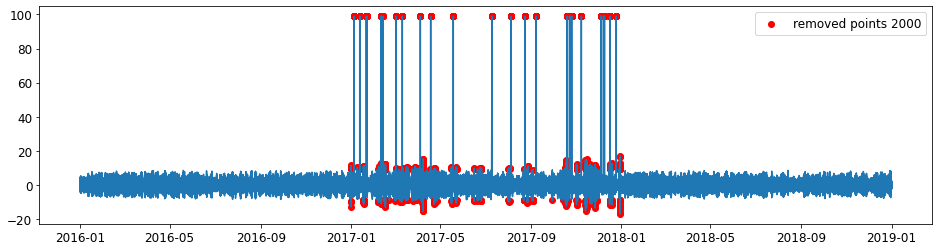

In [67]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(wind.northward)
ax.scatter(time2000, rem2000, c='r', label='removed points 2000')
ax.legend()

In [68]:
wind.drop(time2000,inplace=True)
wind = wind.resample('D').mean()

In [69]:
N=7
wind['smooth_north'] = np.append(running_mean(wind.northward.values,N),np.zeros(N-1))

Text(0.99, 0.9, 'Poleward')

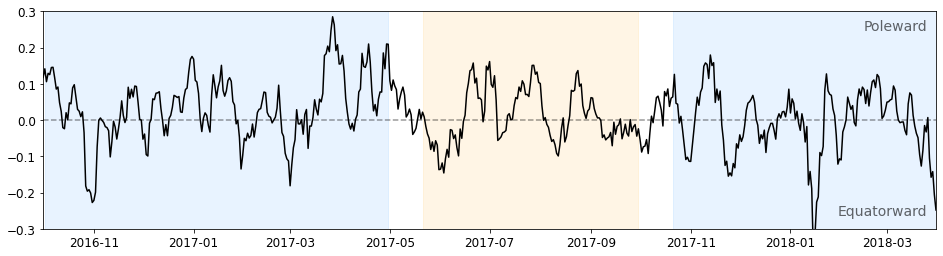

In [70]:
# is this what she meant by principle axis winds?
# couldn't find Austin and Barth 2007 paper

fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(wind.smooth_north, 'k')
ax.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.4)
ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([-0.3,0.3])


ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=9,day=30))&(np.array(dates)>dt.datetime(year=2017,month=5,day=20)), color='orange',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2018,month=3,day=31))&(np.array(dates)>dt.datetime(year=2017,month=10,day=20)), color='dodgerblue',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=4,day=30))&(np.array(dates)>dt.datetime(year=2016,month=10,day=1)), color='dodgerblue',alpha=0.1,zorder=0)

ax.text(.99, .05, "Equatorward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)
ax.text(.99, .9, "Poleward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)

Text(0.99, 0.8, 'Poleward')

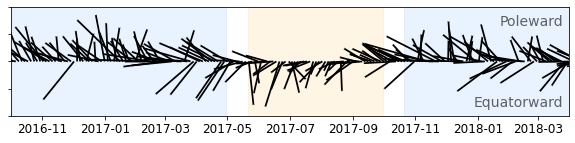

In [71]:
wind_4 = wind.resample('3D').mean()

U = np.cos(wind_4.Wrad) * wind_4.WSPD
V = np.sin(wind_4.Wrad) * wind_4.WSPD

fig, ax = plt.subplots(1,1,figsize=(10,2))
ax.quiver(wind_4.index,np.zeros(len(wind_4.index)),U,V, headwidth=0,scale=50)
ax.set_ylim([-1,1])
ax.set_xlim([dates[0],dates[-1]])
ax.set_yticklabels([])

ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=9,day=30))&(np.array(dates)>dt.datetime(year=2017,month=5,day=20)), color='orange',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2018,month=3,day=31))&(np.array(dates)>dt.datetime(year=2017,month=10,day=20)), color='dodgerblue',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=4,day=30))&(np.array(dates)>dt.datetime(year=2016,month=10,day=1)), color='dodgerblue',alpha=0.1,zorder=0)

ax.text(.99, .05, "Equatorward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)
ax.text(.99, .80, "Poleward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)

In [72]:
# ok lets bring in Fraser River and Columbia River flow
# fraser at hope:
fraser = pd.read_csv('daily_20231124T1831.csv',header=1) # https://wateroffice.ec.gc.ca/download/index_e.html?results_type=historical
fraser.drop(fraser.index[fraser.PARAM == 2],inplace=True)
fraser['Date'] = pd.to_datetime(fraser.Date)
fraser = fraser.set_index('Date')

# columbia at Vancouver washington
columb = pd.read_csv('columbia_vancouverWA.txt',header=27, sep='\t').drop(0) # https://waterdata.usgs.gov/nwis/uv?site_no=14144700&legacy=1
columb['flow'] = pd.to_numeric(columb['218412_00060'])/35.315 # convert from cubic feet to m3
columb['datetime'] = pd.to_datetime(columb.datetime)
columb = columb.set_index('datetime')
columb = columb.resample('D').mean()


<ipython-input-72-abe5f8501f6d>:9: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  columb = pd.read_csv('columbia_vancouverWA.txt',header=27, sep='\t').drop(0) # https://waterdata.usgs.gov/nwis/uv?site_no=14144700&legacy=1


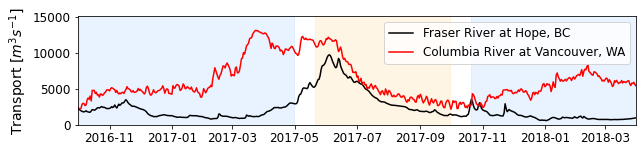

In [73]:
fig, ax = plt.subplots(1,1,figsize=(10,2))

ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([0,15100])
ax.plot(fraser.Value,'k',label='Fraser River at Hope, BC')
ax.plot(columb.flow, 'r', label='Columbia River at Vancouver, WA')
ax.legend()
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)

ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=9,day=30))&(np.array(dates)>dt.datetime(year=2017,month=5,day=20)), color='orange',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2018,month=3,day=31))&(np.array(dates)>dt.datetime(year=2017,month=10,day=20)), color='dodgerblue',alpha=0.1,zorder=0)
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=4,day=30))&(np.array(dates)>dt.datetime(year=2016,month=10,day=1)), color='dodgerblue',alpha=0.1,zorder=0)



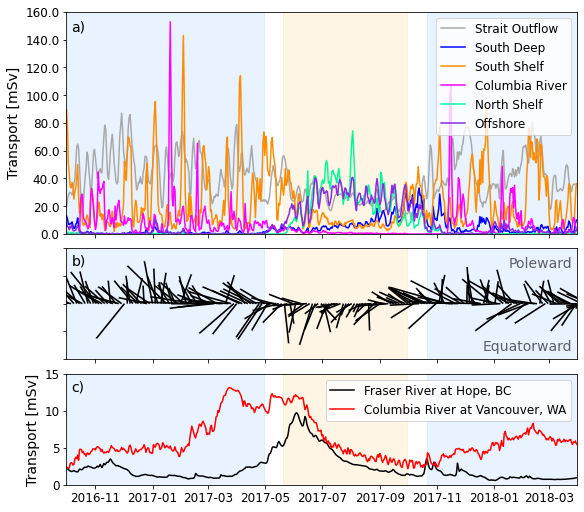

In [79]:
# all three plots of interest together
plt.rcParams['font.size'] = 12

fig = plt.figure(constrained_layout=True, figsize=[8,7])
gs = GridSpec(8, 1, figure=fig)
ax0 = fig.add_subplot(gs[:4,0])
ax1 = fig.add_subplot(gs[4:6,0])
ax2 = fig.add_subplot(gs[6:,0])

for axs in [ax0,ax1,ax2]:
    axs.set_xlim([dates[0],dates[-1]])
    axs.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=9,day=30))&(np.array(dates)>dt.datetime(year=2017,month=5,day=20)), color='orange',alpha=0.1,zorder=0)
    axs.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2018,month=3,day=31))&(np.array(dates)>dt.datetime(year=2017,month=10,day=20)), color='dodgerblue',alpha=0.1,zorder=0)
    axs.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dt.datetime(year=2017,month=4,day=30))&(np.array(dates)>dt.datetime(year=2016,month=10,day=1)), color='dodgerblue',alpha=0.1,zorder=0)

# water mass flow 
N=4
ax0.plot(dates[:-(N-1)], loop_avg, label = "Strait Outflow", c='darkgray')
ax0.plot(dates, cuc, label = "South Deep", c='b')
ax0.plot(dates, south, label = "South Shelf", c='darkorange')
ax0.plot(dates, fresh, label = "Columbia River", c='magenta')
ax0.plot(dates, north, label = "North Shelf", c='mediumspringgreen')
ax0.plot(dates, offshore, label = "Offshore", c='blueviolet')
ax0.legend(loc='upper right')
ax0.set_ylabel('Transport [mSv]',fontsize=14)
ax0.set_ylim([0,160000])
ax0.set_yticks(np.linspace(0,160000,9))
ax0.set_yticklabels(np.linspace(0,160,9))
ax0.set_xticklabels([])
ax0.text(.01, .9, 'a)', ha='left', va='bottom', transform=ax0.transAxes, fontsize=14)

# wind variability
ax1.quiver(wind_4.index,np.zeros(len(wind_4.index)),U,V, headwidth=0,scale=50)
ax1.set_ylim([-1,1])
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.text(.99, .05, "Equatorward", ha='right', va='bottom', alpha=0.6, transform=ax1.transAxes, fontsize=14)
ax1.text(.99, .80, "Poleward", ha='right', va='bottom', alpha=0.6, transform=ax1.transAxes, fontsize=14)
ax1.text(.01, .82, 'b)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=14)


# river flow
ax2.set_ylim([0,15100])
ax2.plot(fraser.Value/1000,'k',label='Fraser River at Hope, BC')
ax2.plot(columb.flow/1000, 'r', label='Columbia River at Vancouver, WA')
ax2.set_ylim([0,15])
ax2.legend()
ax2.set_ylabel('Transport [mSv]',fontsize=14)
ax2.text(.01, .82, 'c)', ha='left', va='bottom', transform=ax2.transAxes, fontsize=14)

plt.savefig("./figures/dailyWMtoJRT.pdf")

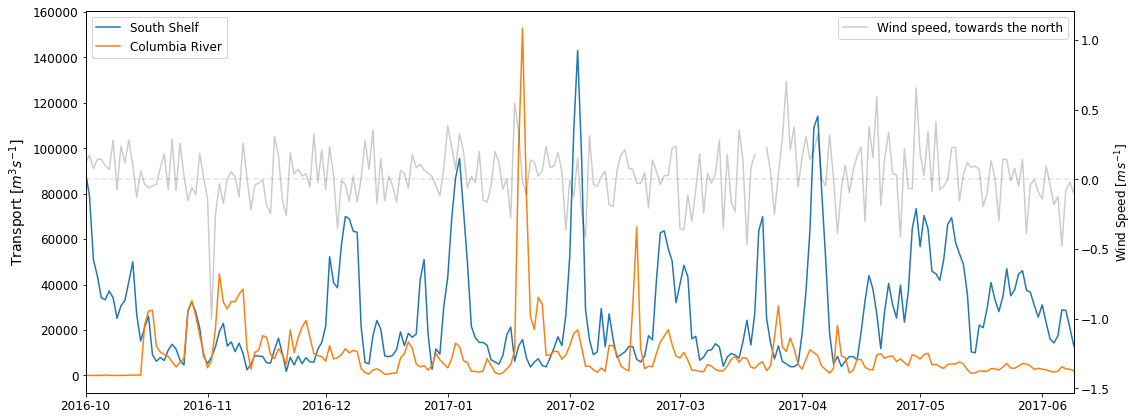

In [30]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates, south, label = "South Shelf")
ax.plot(dates, fresh, label = "Columbia River")

ax2 = ax2=ax.twinx()
ax2.plot(wind.index,wind.northward,c='k', label='Wind speed, towards the north', alpha = 0.2)
ax2.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.1)
ax2.set_ylabel('Wind Speed [$m\,s^{-1}$]')
ax2.plot()

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.set_xlim([dates[0],dates[251]])

plt.tight_layout()
plt.savefig("./figures/columbiawind.pdf")

Text(0, 0.5, 'Cumulative Transport [$m^{3}s^{-1}$]')

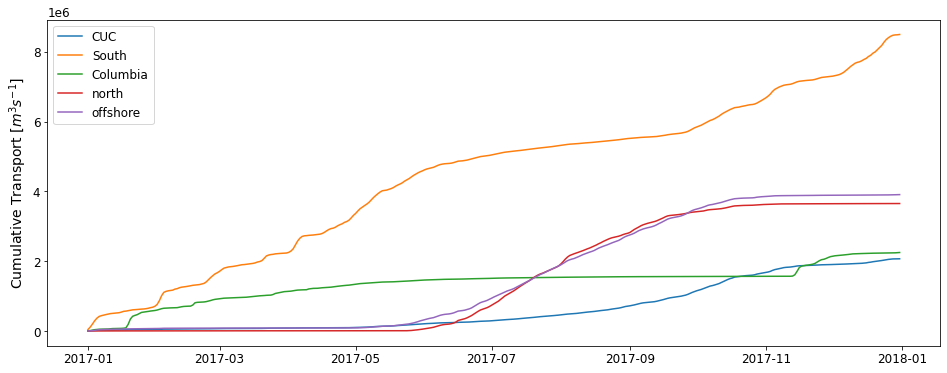

In [31]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates[92:457], np.cumsum(cuc[92:457]), label = "CUC")
ax.plot(dates[92:457], np.cumsum(south[92:457]), label = "South")
ax.plot(dates[92:457], np.cumsum(fresh[92:457]), label = "Columbia")
ax.plot(dates[92:457], np.cumsum(north[92:457]), label = "north")
ax.plot(dates[92:457], np.cumsum(offshore[92:457]), label = "offshore")
ax.legend(loc='upper left')
ax.set_ylabel('Cumulative Transport [$m^{3}s^{-1}$]',fontsize=14)

In [32]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(north[243:364], offshore[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], cuc[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
corr, _ = pearsonr(north[243:364], south[243:364])
print('Pearsons correlation with south: %.3f' % corr)
corr, _ = pearsonr(cuc[243:364], south[243:364])
print('Pearsons correlation cuc and south summer: %.3f' % corr)

Pearsons correlation with offshore: 0.684
Pearsons correlation with cuc: -0.092
Pearsons correlation with south: -0.105
Pearsons correlation cuc and south summer: 0.169


In [33]:
corr, _ = pearsonr(np.append(fresh[:215],fresh[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation fresh and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation cuc and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation cuc and fresh winter: %.3f' % corr)
corr, _ = pearsonr(np.append(south_shallow[:215],south_shallow[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation south shallow and fresh winter: %.3f' % corr)

Pearsons correlation fresh and south winter: -0.118
Pearsons correlation cuc and south winter: 0.292
Pearsons correlation cuc and fresh winter: -0.204
Pearsons correlation south shallow and fresh winter: 0.031


(0.0, 150000.0)

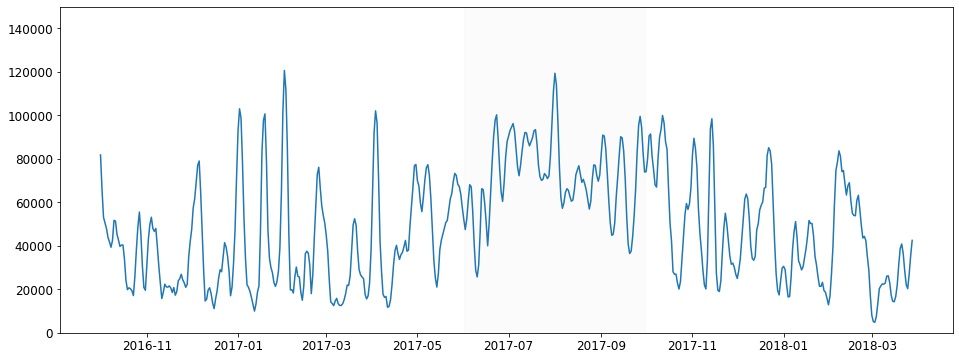

In [34]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
N=4
ax.plot(dates[:-(N-1)], np.sum([running_mean(cuc, N),running_mean(fresh, N),running_mean(north, N),running_mean(south, N),running_mean(offshore, N)],axis=0))
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)
ax.set_ylim([ 0,150000])